<a href="https://colab.research.google.com/github/YoucefBYu/Auto_NLP/blob/master/Fake%20or%20real%20Job%20classificatoin%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#introdction 
we folowed the workflow proposed by google for the text classification problems.
- n-gram model
  - SVC 
  - GB
  - RandomForesr  
- sequencial Models 
  - 

In [ ]:
# to import the csv file from the G drive if you are using you own drive 
# from google.colab import drive
# drive.mount('/content/drive')

# Import 

In [ ]:
# to download the csv file from the drive, 
# This only needs to be done once per notebook.
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

'''Download a file with G ID.
this the link of csv file that we share from drive, the file is share and any one with the link can edit.
              # https://drive.google.com/file/d/1E5eVot87ahE0mjvCfo-vkW8aA_AEENNi
              # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
'''

fileid1 = '1E5eVot87ahE0mjvCfo-vkW8aA_AEENNi'


downloaded1 = drive.CreateFile({'id' : fileid1 })
downloaded1.GetContentFile("fake_job_postings")

In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import csv
import datetime
#scikitlearn
import sklearn
from sklearn import preprocessing, model_selection, pipeline
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC 
from sklearn.metrics import f1_score, roc_auc_score , recall_score , accuracy_score, classification_report ,plot_confusion_matrix
# tensorflow
import tensorflow as tf
import datetime
#keras
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

#SpaCy
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import re, string, unicodedata
import nltk

import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

# Parameter


In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .7

* Loading the csv file using pandas 

In [ ]:
data = pd.read_csv("/content/fake_job_postings") 


#data = pd.read_csv("/content/drive/My Drive/Datasets/fake_job_postings.csv") 

# Exploring the data 


* Dimension and content

In [ ]:
print("Data dimension :",data.shape)
data.head()

Data dimension : (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


* Checking the data type of columns

In [ ]:
data.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

* Checking the distrubution of numerical columns.

In [ ]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


## Visualisation of the missing data in the dataset
the columns "departement" and "Salary range" should be deleted in this case because the number of Nan values is very high.

we focus on the columns that make the model learn and give a high accuracy. 

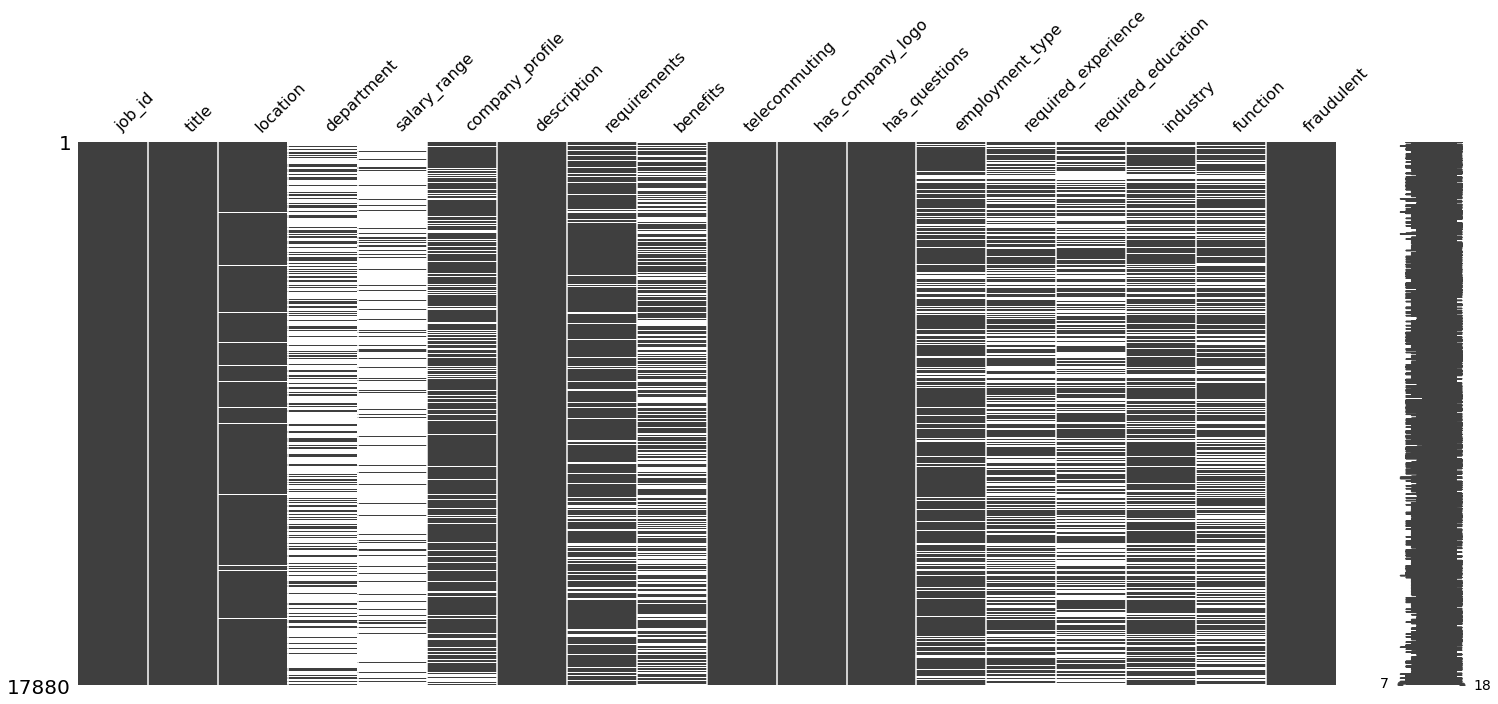

In [ ]:
missingno.matrix(data)

In [ ]:
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

## Plot of the correlation between features 

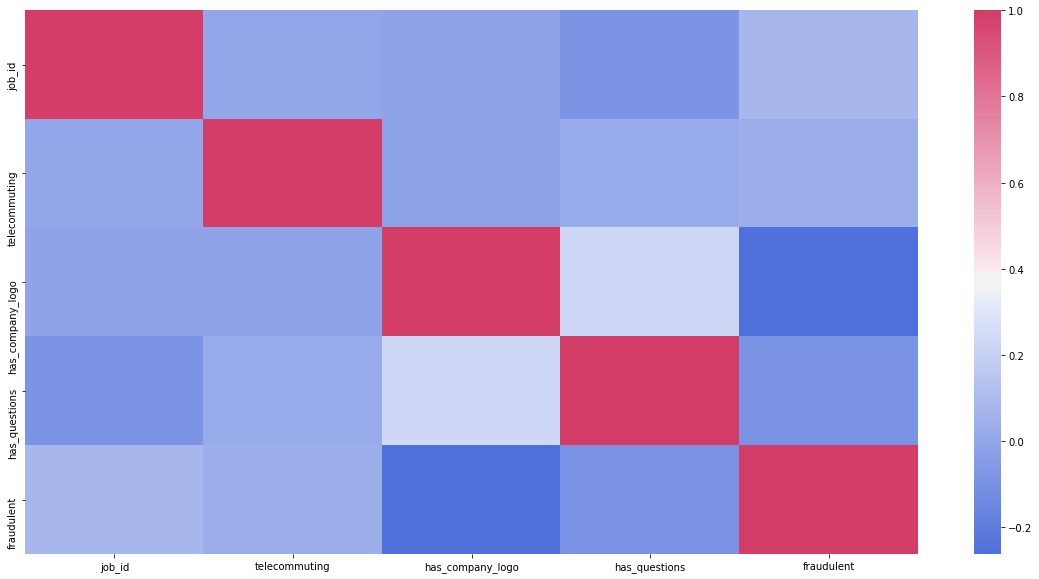

In [ ]:
plt.figure(figsize = (20,10))
correlation = data.corr()
sns.heatmap(correlation , mask=np.zeros_like(correlation, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) )

In [ ]:
data.fillna(' ', inplace=True)

## Collect Key Metrics

- Number of samples: 17880

- Number of classes: 2 classes fake or real.

- Number of samples per class: 
  - Real Job class (label 1) : 866
  - Fake Job class (label 0) : 17014

note: 
In a balanced dataset, all classes will have a similar number of samples; 
in an imbalanced dataset, the number of samples in each class will vary widely.

      - Number of words per sample: Median number of words in one sample.
      - Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.
      - Distribution of sample length: Distribution showing the number of words per sample in the dataset.

## Checking the bias of labels


The ratio of jobs classified as real is 17014/17880 wich means 95% of data labled as real.

We can say that the first problem is Label bias.


We suggest two solution in this case:
- Text data augmentation [paper](),[repo](https://github.com/dsfsi/textaugment)
- Semi-Supervised Labeling(we didn't implement this solution)
- 

Ref : 
  - [4-approaches-to-overcoming-label-bias-in-positive-and-unlabeled-learning](https://blogs.oracle.com/datascience/4-approaches-to-overcoming-label-bias-in-positive-and-unlabeled-learning#:~:text=Label%20bias%20occurs%20when%20the,which%20is%20difficult%20and%20expensive).

In [ ]:
data.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title')

,fraudulent,title
1,1,866
0,0,17014


# Preparing and Preprocessing the data 

 ## Merege and clean text features  
  - merge all the text features of original data to the new data frame 'text_data'.
  - Fill NAN values with empty string.
  - sperate the numerical futures.

In [ ]:
labels = data[["fraudulent"]]
text_data = pd.DataFrame(columns =['text'],data = data['title']+' '+data['description']+' '+data['company_profile']+' '+data['requirements']+' '+data['benefits']+' '+data['location']+' '+ data['department']+' '+' '+data['employment_type']+' '+data['required_experience']+' '+data['required_education']+' '+data['industry']+' '+data['function'])
# text_data['labels']= labels
text_data.head()

,text
0,"Marketing Intern Food52, a fast-growing, James..."
1,Customer Service - Cloud Video Production Orga...
2,Commissioning Machinery Assistant (CMA) Our cl...
3,Account Executive - Washington DC THE COMPANY:...
4,Bill Review Manager JOB TITLE: Itemization Rev...


In [ ]:
num_data = data[["telecommuting", "has_company_logo", "has_questions"]]
num_data = num_data.fillna("None")
num_data.head()

,telecommuting,has_company_logo,has_questions
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,1


In [ ]:
# these funcions are for clculating some feature metrics 
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [ ]:
text_data=text_data['text']

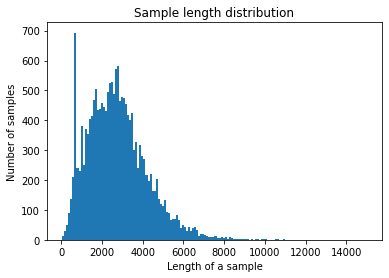

In [ ]:

def plot_sample_length_distribution(text):
    number =[]
    for i in text :
      number.append(np.median(len(i.split())))

    plt.hist([len(s) for s in text], 150)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

plot_sample_length_distribution(text_data)

## Tokenization

* defining the Tokenization and padding parameters for keras models 

In [ ]:
vocab_size = 100000
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

Tokenization with Spacy and Keras: 
1- load spacy stopwords lists

In [ ]:
spacy_nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

2 - Creating a list of sentences without stopwords 

In [ ]:
sentences = []
for sentence in text_data:
         for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
         sentences.append(sentence)

### Data random split to train, validation and testset using scikitlear 

- Rename the variables to simplify the work with models 

In [ ]:
X = sentences
y = labels

### Keras Tokenization and padding 

Toekinization and padding Parameters 


* this function  englobes three steps wich are :

  1.   spliting the data to Train, Validation ,Test sets using scikitlearn  keras sequential model. 

  2.   Toekinize the word 

  3. create the padded tensors.
  4. transform the dataframes of labels to nupyarray to fead it to the TF.kearas model.

In [ ]:
training_portion = .7
VALIDATION_SIZE=0.3 
TEST_SIZE=0.2

In [ ]:

#def token_padd_split_data(X,y,val_size=0.3 ,test_size=0.2, vocab_size=10000,oov_token="<OOV>" ,padding_type='post',  max_length= 200)
# we use global variable in this fuction 
def token_padd_split_data(X,y):
      '''  
      this function take as input the features and the labels, and give as output  the vectorised and padded sets (train,val,test) 
      - this function englobes three steps wich are :

        1.   spliting the data to Train, Validation ,Test sets using scikitlearn  keras sequential model. 
        2.   Toekinize the word 
        3. create the padded tensors.
        4. transform the dataframes of labels to nupyarray to fead it to the TF.kearas model.  
              this function take as input the features and the labels, and give as output  the vectorised and padded sets (train,val, test)
      
      '''
      # Split 
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= TEST_SIZE, random_state=0)
      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= VALIDATION_SIZE, random_state=0)

      # tokinization and padding 
      #filters='!"#$%&()*+,-./:;<=>?...'
      tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok ,lower=True, split=',')
      tokenizer.fit_on_texts(X_train)
      word_index = tokenizer.word_index

      train_sequences = tokenizer.texts_to_sequences(X_train)
      train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

      validation_sequences = tokenizer.texts_to_sequences(X_val)
      validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

      test_sequences = tokenizer.texts_to_sequences(X_test)
      test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
      
      # transforming the dtaframe of tokinized word to numpy array
      training_labels= np.array(y_train)
      validation_labels = np.array(y_val)
      test_labels = np.array(y_test)

      
      return train_padded,validation_padded,test_padded, training_labels, validation_labels, test_labels,tokenizer

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test,tokenizer = token_padd_split_data(X,y)

checking the shape and lenght of sets after the split 

In [ ]:
print(tokenizer.index_word)
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Processing the Data 
Building, Training and Evaluation of models 

in this notebook we use the pipeline of the NLP classification task, suggested by [Googl ML developers guide](https://developers.google.com/machine-learning/guides/text-classification/step-2-5).


## Sequential model 

- We used a simple sequencial model because we have a small dataset.

  - Configuration of Sequencial model: 
        1- Embedding layer :
           parameters: (the parameter are defined as Global variables that chage over time)
              - vocab size 
              - embedding dim
              - input length
        2- Global Average Pooling 1D
        3- Dense layer with 
              - 24 units
              - activation = relu
        4- output layer (
              - 2 units 
              - activation = softmax

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 16)           1600000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 50        
Total params: 1,600,458
Trainable params: 1,600,458
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
num_epochs = 10
log_dir = "logs/fit/SEQ" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data =(X_val, y_val), verbose=2, callbacks=[tensorboard_callback])

Epoch 1/10
313/313 - 5s - loss: 0.3043 - accuracy: 0.9412 - val_loss: 0.1862 - val_accuracy: 0.9525
Epoch 2/10
313/313 - 5s - loss: 0.1833 - accuracy: 0.9492 - val_loss: 0.1643 - val_accuracy: 0.9525
Epoch 3/10
313/313 - 5s - loss: 0.1246 - accuracy: 0.9584 - val_loss: 0.0956 - val_accuracy: 0.9664
Epoch 4/10
313/313 - 5s - loss: 0.0631 - accuracy: 0.9777 - val_loss: 0.0697 - val_accuracy: 0.9781
Epoch 5/10
313/313 - 5s - loss: 0.0396 - accuracy: 0.9862 - val_loss: 0.0598 - val_accuracy: 0.9804
Epoch 6/10
313/313 - 5s - loss: 0.0289 - accuracy: 0.9904 - val_loss: 0.0570 - val_accuracy: 0.9835
Epoch 7/10
313/313 - 5s - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.0541 - val_accuracy: 0.9828
Epoch 8/10
313/313 - 5s - loss: 0.0182 - accuracy: 0.9937 - val_loss: 0.0546 - val_accuracy: 0.9825
Epoch 9/10
313/313 - 5s - loss: 0.0149 - accuracy: 0.9951 - val_loss: 0.0536 - val_accuracy: 0.9846
Epoch 10/10
313/313 - 5s - loss: 0.0128 - accuracy: 0.9964 - val_loss: 0.0569 - val_accuracy: 0.9825

In [ ]:
model.evaluate(X_test,y_test)

112/112 [==============================] - 0s 3ms/step - loss: 0.0538 - accuracy: 0.9832


[0.053766537457704544, 0.9832214713096619]

### TensorBoard visualisation 

In [ ]:
%tensorboard --logdir logs/fit

* this code to visualize the embedded Words 

In [ ]:
from tensorboard.plugins import projector
def tonsorboard_plt(log_dir , model, stopwords) :
    # Set up a logs directory, so Tensorboard knows where to look for files
    word_index = tokenizer.word_index
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    def decode_sentence(text):
        return ' '.join([reverse_word_index.get(i, '?') for i in text])
    e = model.layers[0]
    weights = e.get_weights()[0]    

    
    # Set up a logs directory, so Tensorboard knows where to look for files
    log_dir='logs/LogEmbedd'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # Save Labels separately on a line-by-line manner.
    with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
      # Fill in the rest of the labels with "unknown"
      for word_num in range(1, vocab_size - 4372):
        word = reverse_word_index[word_num]
        embeddings = weights[word_num]
        f.write(" {}\n".format(word))
        # f.write('\t'.join([str(x) for x in embeddings]) + "\n")   


    # Save the weights we want to analyse as a variable. Note that the first
    # value represents any unknown word, which is not in the metadata, so
    # we will remove that value.
    weights = tf.Variable(model.layers[0].get_weights()[0][1:])
    # Create a checkpoint from embedding, the filename and key are
    # name of the tensor.
    checkpoint = tf.train.Checkpoint(embedding=weights)
    checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

    # Set up config
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    # The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
    embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
    embedding.metadata_path = 'metadata.tsv'
    projector.visualize_embeddings(log_dir, config)

In [ ]:
#tonsorboard_plt(log_dir ='logs/model',model= model,stopwords=stopwords)

- note you should chose projector to see the 

In [ ]:
%tensorboard --logdir logs/LogEmbedd

In [ ]:
# def plot_graphs(history, string):
#   plt.plot(history.history[string])
#   plt.plot(history.history['val_'+string])
#   plt.xlabel("Epochs")
#   plt.ylabel(string)
#   plt.legend([string, 'val_'+string])
#   plt.show()
  
# plot_graphs(history, "accuracy")
# plot_graphs(history, "loss")

In [ ]:

# log_dir='logs/LogEmbedd'
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

# # Save Labels separately on a line-by-line manner.
# with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
#   for word_num in range(1, vocab_size - 4372):
#     word = reverse_word_index[word_num]
#     embeddings = weights[word_num]
#     f.write("{}\n".format(word))
#     # f.write('\t'.join([str(x) for x in embeddings]) + "\n")    


# # Save the weights we want to analyse as a variable. Note that the first
# # value represents any unknown word, which is not in the metadata, so
# # we will remove that value.
# weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# # Create a checkpoint from embedding, the filename and key are
# # name of the tensor.
# checkpoint = tf.train.Checkpoint(embedding=weights)
# checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# # Set up config
# config = projector.ProjectorConfig()
# embedding = config.embeddings.add()
# # The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
# embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
# embedding.metadata_path = 'metadata.tsv'
# projector.visualize_embeddings(log_dir, config)

In [ ]:
%tensorboard --logdir logs/LogEmbedd

## LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 24),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 24)          2400000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 48)                9408      
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 2,410,609
Trainable params: 2,410,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
# y_val =y_val.T



(10012, 200)


ValueError: ignored

In [ ]:
# np.concatenate((X_val,y_val), axis =1)
# val_data = X_val

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1])

val_data = val_data.reshape(val_data.shape[1],val_data.shape[2])
# val_data.shape

In [ ]:
print(X_train.shape)
print(y_train.shape)

(10012, 200)
(10012, 1)


In [ ]:
num_epochs = 10
num_epochs = 10
log_dir = "logs/fit/LSTM" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x= X_train,y= y_train, epochs=num_epochs, validation_data =(val_data,y_val), callbacks=[tensorboard_callback])

Epoch 1/10
313/313 [==============================] - 18s 57ms/step - loss: 0.0444 - accuracy: 0.9864 - val_loss: 0.0602 - val_accuracy: 0.9828
Epoch 2/10
313/313 [==============================] - 17s 54ms/step - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.0674 - val_accuracy: 0.9821
Epoch 3/10
313/313 [==============================] - 17s 54ms/step - loss: 0.0119 - accuracy: 0.9958 - val_loss: 0.0750 - val_accuracy: 0.9744
Epoch 4/10
313/313 [==============================] - 17s 53ms/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.0749 - val_accuracy: 0.9825
Epoch 5/10
313/313 [==============================] - 17s 54ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.1180 - val_accuracy: 0.9704
Epoch 6/10
313/313 [==============================] - 17s 54ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0801 - val_accuracy: 0.9832
Epoch 7/10
313/313 [==============================] - 17s 55ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0796 - val_accuracy:

In [ ]:
model.evaluate(X_test,y_test)

112/112 [==============================] - 2s 14ms/step - loss: 0.1332 - accuracy: 0.9829


[0.13321153819561005, 0.9829418063163757]

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:

# def plot_graphs(history, string):
#   plt.plot(history.history[string])
#   plt.plot(history.history['val_'+string])
#   plt.xlabel("Epochs")
#   plt.ylabel(string)
#   plt.legend([string, 'val_'+string])
#   plt.show()
#   plot_graphs(history, 'accuracy')
#   plot_graphs(history, 'loss')

  

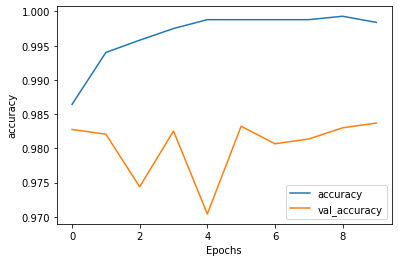

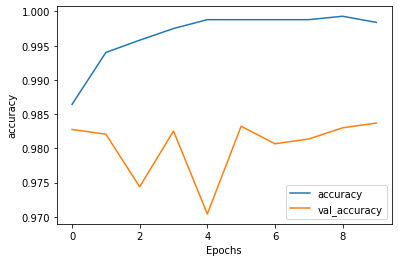

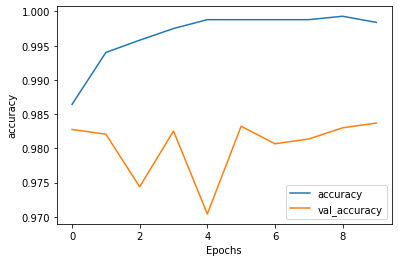

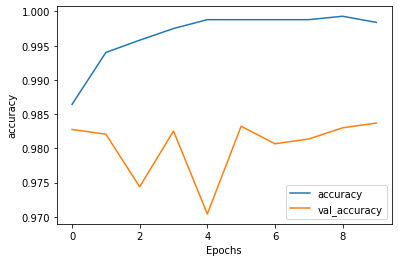

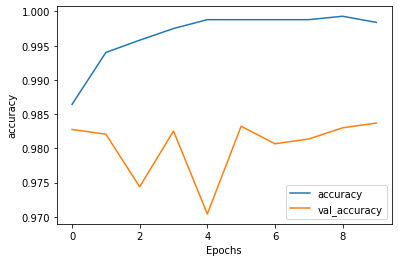

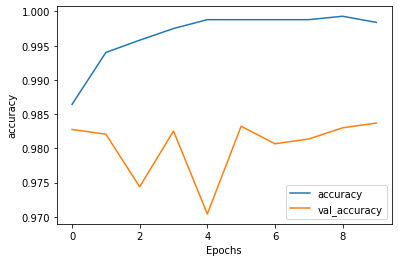

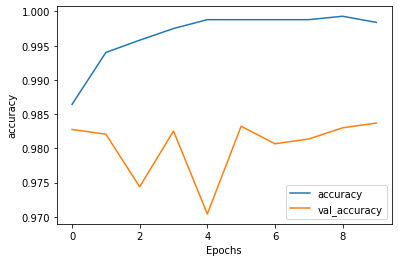

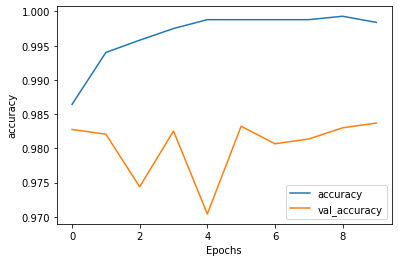

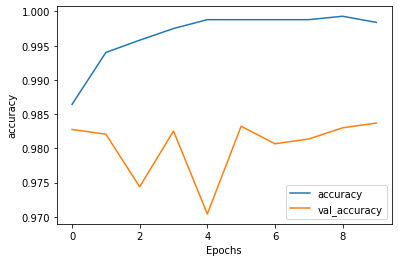

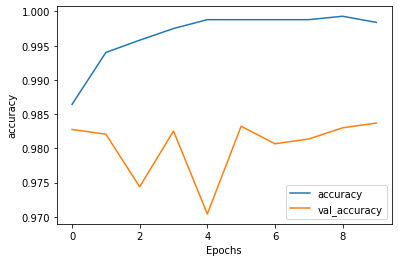

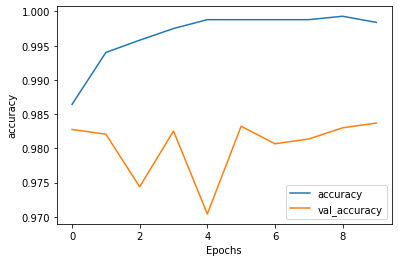

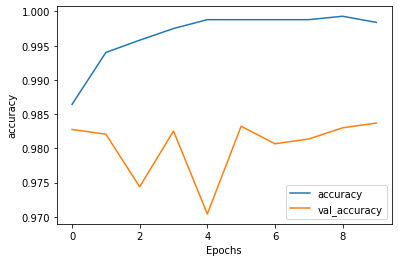

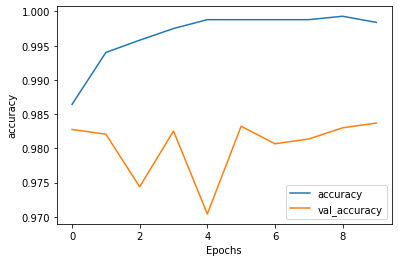

KeyboardInterrupt: ignored

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
# plot_graphs(history, 'loss')

## Ktrain and Bert 

In [ ]:
# (_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
#                                                                    'text', # name of column containing review text
#                                                                    label_columns=['neg', 'pos'],
#                                                                    maxlen=75, 
#                                                                    max_features=100000,
#                                                                    preprocess_mode='standard',
#                                                                    val_pct=0.1,
#                                                                    ngram_range=3)

## ML models 

In [ ]:
# Create our list of stopwords
nlp = spacy.load('en')
punctuations = string.punctuation
stopwords = spacy.lang.en.stop_words.STOP_WORDS
parser = English()
tokens = []

def clean_text(text):
    ''''''
    # Removing spaces and converting text into lowercase
    return text.strip().lower()
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
      return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
      return self

    def get_params(self, deep=True):
      return {}


def spacy_tokenizer(sentence):
    ''''''   
    tokens = parser(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in stopwords and word not in punctuations ]

    # return preprocessed list of tokens
    return tokens

### Suport Victor Machine 

In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = y_train.reshape(len(y_train))
y_test = y_test.reshape(len(y_test))

In [ ]:
clf = SVC()
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])
# fitting our model.
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)

In [ ]:
# print(predicted)

In [ ]:
# Model Accuracy
# print("SVC Accuracy:", accuracy_score(y_test, predicted))
# print("SVC Recall:", recall_score(y_test, predicted))
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')
print(classification_report(y_true= y_test, y_pred=predicted))

### Random forest 

In [ ]:
clf = RandomForestClassifier()

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

pipe.fit(X_train,y_train)

In [ ]:
predicted = pipe.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))





In [ ]:
print(classification_report(y_true= y_test, y_pred=predicted))
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

In [ ]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

# Conclusion 
after the application of the N-gram and sequential model on this data set we reached a good accurracy on validation and test sets, but the problem of label bias must be solves bu adding more data.
the sequentail model 